Disclaimer: The daily_orders operational metrics used in this analysis are synthetically generated (mock data) for portfolio demonstration purposes to simulate business logic. Weather and pollution data are authentic, sourced from Open-Meteo API.

In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [28]:
# db_path = "sqlite:///data/jakarta_pulse.db"
db_path = r"sqlite:////Users/Axioo Pongo/Portofolio DA/Jakarta Daily/my-airflow-templates/data/jakarta_pulse.db"
engine = create_engine(db_path)

In [29]:
query_master = """
    SELECT 
        o.time,
        o.total_orders,
        o.average_delivery_time,
        w.temperature,
        w.wind_speed,
        w.precipitation,
        p.pm_25, 
        p.nitrogen_dioxide
    FROM daily_orders o
    INNER JOIN weather w ON o.time = w.time
    INNER JOIN polutan p ON w.time = p.time
    ORDER BY o.time ASC;
"""

df_master = pd.read_sql(query_master, engine)
df_master.head()

,time,total_orders,average_delivery_time,temperature,wind_speed,precipitation,pm_25,nitrogen_dioxide
0,2025-02-20 00:00:00,14,24,25.2,5.0,0.2,111.3,80.6
1,2025-02-20 01:00:00,11,24,25.1,4.0,0.9,101.7,79.4
2,2025-02-20 02:00:00,15,23,25.0,2.9,1.2,91.7,77.2
3,2025-02-20 03:00:00,17,22,24.9,2.3,1.7,82.7,74.7
4,2025-02-20 04:00:00,28,19,24.9,1.6,0.1,79.6,73.6


# Business Problem
1. Surge Pricing Algorithm Optimization (Weather Impact on Delivery)
2. NO2 Emissions as a Traffic Proxy (Weekday vs. Weekend Mobility)
3. Health-Tech Marketing Opportunities (Temperature & PM2.5 Correlation)
4. The "Washout" Effect (Post-Rain Pollution Dynamics & Upsell Strategy)

In [30]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time                   8760 non-null   object 
 1   total_orders           8760 non-null   int64  
 2   average_delivery_time  8760 non-null   int64  
 3   temperature            8760 non-null   float64
 4   wind_speed             8760 non-null   float64
 5   precipitation          8760 non-null   float64
 6   pm_25                  8760 non-null   float64
 7   nitrogen_dioxide       8760 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 547.6+ KB


In [31]:
df_master['time'] = pd.to_datetime(df_master['time'])
df_master['date'] = df_master['time'].dt.date
df_master['hour'] = df_master['time'].dt.hour
df_master['is_weekend'] = df_master['time'].dt.dayofweek >= 5

df_master.head()

,time,total_orders,average_delivery_time,temperature,wind_speed,precipitation,pm_25,nitrogen_dioxide,date,hour,is_weekend
0,2025-02-20 00:00:00,14,24,25.2,5.0,0.2,111.3,80.6,2025-02-20,0,False
1,2025-02-20 01:00:00,11,24,25.1,4.0,0.9,101.7,79.4,2025-02-20,1,False
2,2025-02-20 02:00:00,15,23,25.0,2.9,1.2,91.7,77.2,2025-02-20,2,False
3,2025-02-20 03:00:00,17,22,24.9,2.3,1.7,82.7,74.7,2025-02-20,3,False
4,2025-02-20 04:00:00,28,19,24.9,1.6,0.1,79.6,73.6,2025-02-20,4,False


## 1. Surge Pricing Algorithm Optimization (Weather Impact on Delivery)
How do varying intensities of rainfall and wind speed impact our average delivery time, and at what specific weather thresholds should the algorithm trigger Surge Pricing to maintain driver supply?

In [32]:
def rain_category(x):
    if x > 7.5:
        return 'Heavy rain'
    if x > 2.5:
        return 'Raining'
    if x > 0.0:
        return 'Drizzling'
    if x == 0.0:
        return 'Sunny'
    return 'Unknown'

df_master['rain_category'] = df_master['precipitation'].apply(rain_category)
df_master['rain_category'].value_counts()

rain_category
Sunny         5685
Drizzling     2778
Raining        268
Heavy rain      29
Name: count, dtype: int64

In [33]:
def wind_category(x):
    if x > 20:
        return 'Strong Winds (>20 km/h)'
    if x >= 10:
        return 'Moderate Winds (10-20 km/h)'
    if x < 10:
        return 'Light Winds(<10 km/h)'
    return 'Unknown'

df_master['wind_category'] = df_master['wind_speed'].apply(wind_category)
df_master['wind_category'].value_counts()

wind_category
Light Winds(<10 km/h)          6682
Moderate Winds (10-20 km/h)    2045
Strong Winds (>20 km/h)          33
Name: count, dtype: int64

In [34]:
print(df_master['average_delivery_time'].mean())
print(df_master['total_orders'].mean())

22.21598173515982
73.52545662100457


In [35]:
surge_analysis = df_master.groupby(['rain_category']).agg({
    'time': 'count',
    'total_orders': 'mean',
    'average_delivery_time': 'mean'
}).round(1).sort_values(by='total_orders', ascending=True)
surge_analysis

,time,total_orders,average_delivery_time
rain_category,,,
Sunny,5685,64.4,21.8
Heavy rain,29,74.2,22.2
Raining,268,89.2,23.3
Drizzling,2778,90.6,23.0


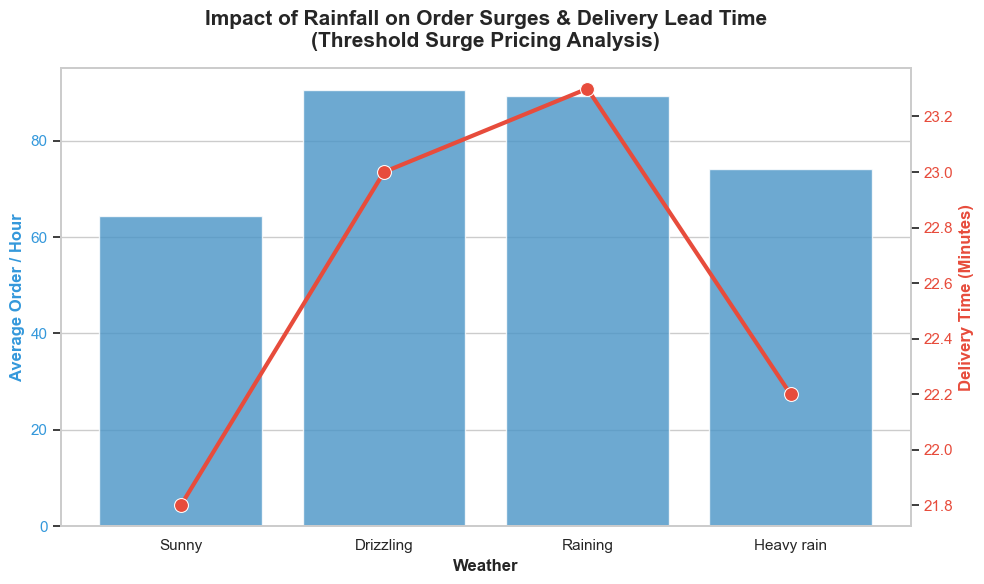

In [36]:
weather_ordered = ['Sunny', 'Drizzling', 'Raining', 'Heavy rain']

df_plot = surge_analysis.reset_index()

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

color_bar = '#3498db'
sns.barplot(
    data=df_plot, 
    x='rain_category', 
    y='total_orders', 
    order=weather_ordered, 
    color=color_bar, 
    ax=ax1,
    alpha=0.8
)
ax1.set_ylabel('Average Order / Hour', color=color_bar, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_bar)
ax1.set_xlabel('Weather', fontsize=12, fontweight='bold')


ax2 = ax1.twinx()
color_line = '#e74c3c'
df_line = df_plot.set_index('rain_category').reindex(weather_ordered).reset_index()

sns.lineplot(
    data=df_line, 
    x='rain_category', 
    y='average_delivery_time', 
    color=color_line, 
    marker='o', 
    linewidth=3, 
    markersize=10, 
    ax=ax2,
    sort=False
)
ax2.set_ylabel('Delivery Time (Minutes)', color=color_line, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_line)
ax2.grid(False)

plt.title('Impact of Rainfall on Order Surges & Delivery Lead Time\n(Threshold Surge Pricing Analysis)', fontsize=15, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

Observation:
The data indicates a clear correlation between weather conditions and operational metrics. As weather shifts from 'Sunny' to 'Drizzling' and 'Raining', we see a significant spike in order volume (from 64.4 to 90.6 orders/hour) accompanied by an increase in average delivery time.

Business Recomendation:
Implement a multi-tiered Surge Pricing algorithm. Trigger Level 1 Surge during 'Drizzling' conditions to capture the demand spike while maintaining driver supply. Trigger Level 2 Surge during 'Raining' conditions with 'Moderate/Strong Winds' to compensate for the severe drop in delivery speed and higher safety risks for drivers.

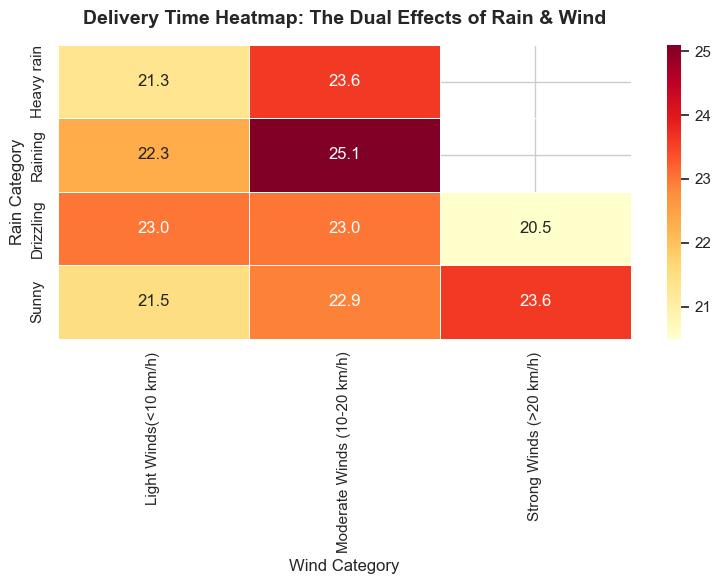

In [37]:
weather_ordered = ['Heavy rain', 'Raining', 'Drizzling', 'Sunny']
weather_matrix = df_master.pivot_table(
    values='average_delivery_time',
    index='rain_category',
    columns='wind_category',
    aggfunc='mean'
).round(1).reindex(weather_ordered)

plt.figure(figsize=(8, 6))

sns.heatmap(weather_matrix, annot=True, cmap='YlOrRd', fmt='.1f', linewidths=.5)
plt.title('Delivery Time Heatmap: The Dual Effects of Rain & Wind', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Wind Category', fontsize=12)
plt.ylabel('Rain Category', fontsize=12)
plt.tight_layout()
plt.show()

- Observing the dark red cell indicating a peak of 25.1 minutes at the intersection of 'Raining' and 'Moderate Winds': This serves as concrete evidence that operations are most severely impacted when rain is coupled with relatively strong winds. Consequently, this is the exact scenario where Surge Pricing must be activated at its maximum tier.
- Regarding the empty (blank) areas located at the intersections of 'Raining' + 'Strong Winds' and 'Heavy Rain' + 'Strong Winds': This indicates that over the past year of extracted data, Jakarta did not experience any instances where moderate-to-heavy rainfall coincided with gale-force winds (>20 km/h) within the exact same hour.

## 2. NO2 Emissions as a Traffic Proxy (Weekday vs. Weekend Mobility)
Can Nitrogen Dioxide (NO2) levels serve as a reliable, cost-effective proxy for real-time traffic congestion? Do NO2 concentrations align with traditional rush hour patterns on weekdays compared to weekends?

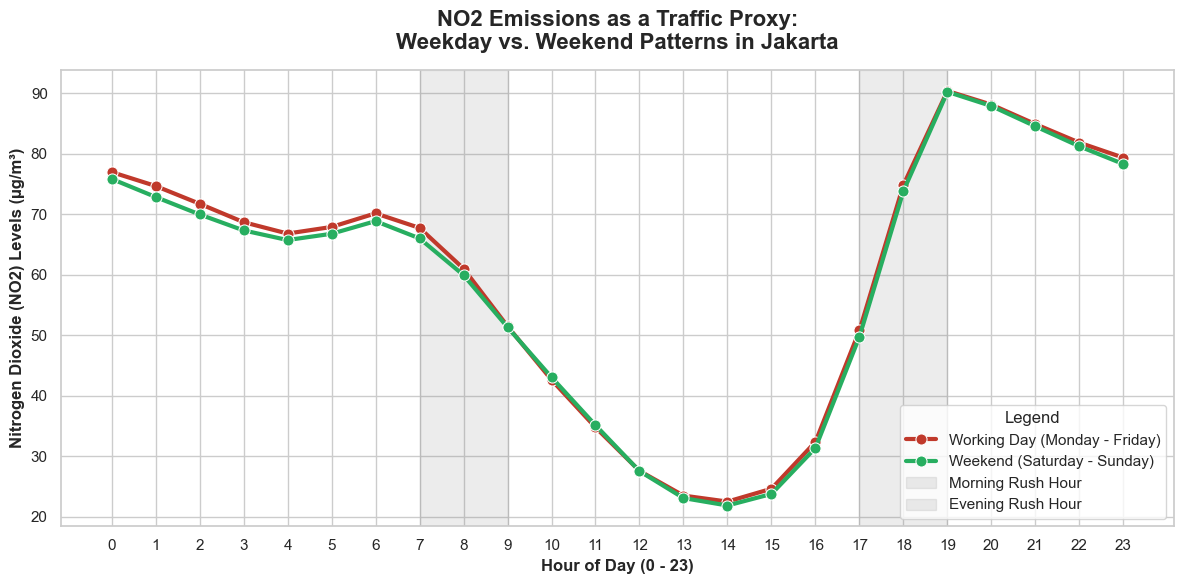

In [38]:
df_no2 = df_master.groupby(['hour', 'is_weekend'])['nitrogen_dioxide'].mean().reset_index()

def day_category(x):
    if x == False:
        return 'Working Day (Monday - Friday)'
    if x == True:
        return 'Weekend (Saturday - Sunday)'

df_no2['day'] = df_no2['is_weekend'].apply(day_category)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df_no2, 
    x='hour', 
    y='nitrogen_dioxide', 
    hue='day', 
    palette=['#c0392b', '#27ae60'], 
    linewidth=3, 
    marker='o',
    markersize=8
)

plt.axvspan(7, 9, color='gray', alpha=0.15, label='Morning Rush Hour')
plt.axvspan(17, 19, color='gray', alpha=0.15, label='Evening Rush Hour')
plt.title('NO2 Emissions as a Traffic Proxy:\nWeekday vs. Weekend Patterns in Jakarta', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Hour of Day (0 - 23)', fontsize=12, fontweight='bold')
plt.ylabel('Nitrogen Dioxide (NO2) Levels (µg/m³)', fontsize=12, fontweight='bold')
plt.xticks(range(0, 24))
plt.legend(loc='lower right', title='Legend')
plt.tight_layout()
plt.show()

Observation:
The initial hypothesis that NO2 peaks during rush hours was proven false. Due to the Photolysis effect (sunlight breaking down NO2) and Thermal Inversion, NO2 levels actually plummet during the day and skyrocket at night (peaking at ~80 µg/m³ between 22:00 - 23:00). Furthermore, macro-level satellite API data lacks the granularity to differentiate weekday vs. weekend street-level traffic.

Business Recommendation: 
Pivot from using NO2 as a traffic ETA proxy. Instead, address a critical operational risk: Driver Welfare. Night-shift logistics drivers are exposed to hazardous NO2 levels exceeding the WHO and national daily safe limits. The company should mandate and provide N95/KN95 masks as part of the standard safety gear for night-shift fleets to mitigate long-term health liabilities.

## 3. Health-Tech Marketing Opportunities (Temperature & PM2.5 Correlation)
How does the Thermal Inversion effect (temperature drops trapping PM2.5 particles) create extreme pollution peaks, and what is the exact 'Golden Hour' to trigger automated push notifications for our Telemedicine products (masks and vitamins) to maximize conversion rates?

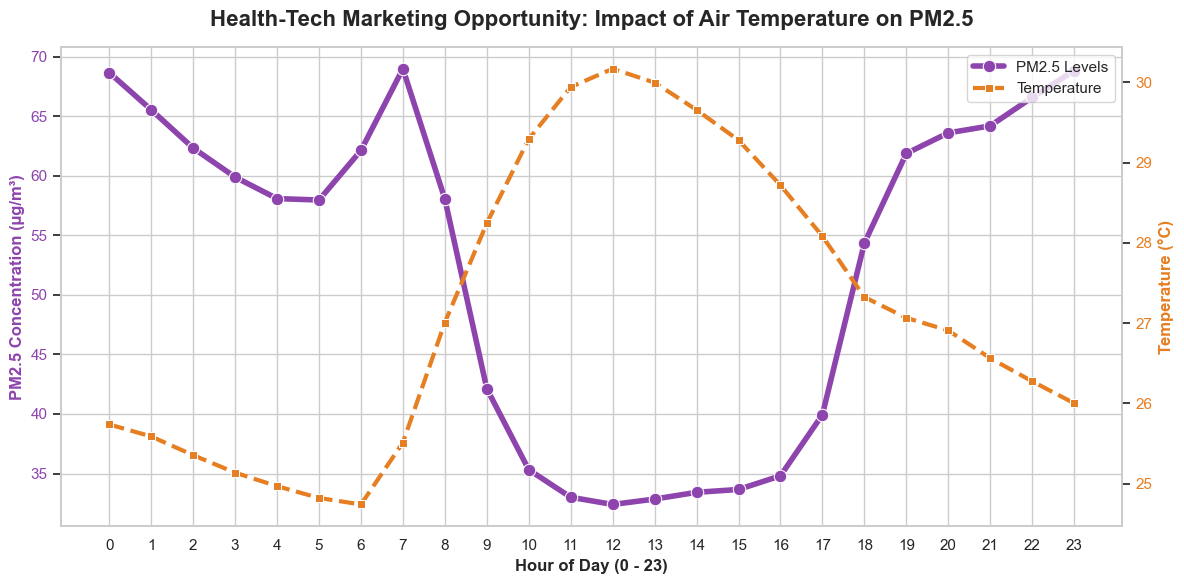

In [39]:
df_health = df_master.groupby('hour').agg({
    'temperature': 'mean',
    'pm_25': 'mean'
}).reset_index()

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

color_pm = '#8e44ad'
sns.lineplot(
    data=df_health, 
    x='hour', 
    y='pm_25', 
    color=color_pm, 
    linewidth=4, 
    marker='o',
    markersize=9,
    ax=ax1,
    label='PM2.5 Levels'
)
ax1.set_ylabel('PM2.5 Concentration (µg/m³)', color=color_pm, fontsize=12, fontweight='bold') 
ax1.tick_params(axis='y', labelcolor=color_pm)
ax1.set_xlabel('Hour of Day (0 - 23)', fontsize=12, fontweight='bold') 
ax1.set_xticks(range(0, 24))

ax2 = ax1.twinx()
color_temp = '#e67e22' 
sns.lineplot(
    data=df_health, 
    x='hour', 
    y='temperature', 
    color=color_temp, 
    linewidth=3, 
    marker='s',
    linestyle='--', 
    ax=ax2,
    label='Temperature'
)
ax2.set_ylabel('Temperature (°C)', color=color_temp, fontsize=12, fontweight='bold') 
ax2.tick_params(axis='y', labelcolor=color_temp)
ax2.grid(False) 

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
ax2.get_legend().remove() 

plt.title('Health-Tech Marketing Opportunity: Impact of Air Temperature on PM2.5', fontsize=16, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

Strategic Segmentation: While 07:00 AM is the absolute peak of PM2.5, sending promotional push notifications at this exact hour on weekends will likely result in low conversion rates and high user annoyance.

Action Item: The Marketing automation system must include a day_of_week logic gate.
- Weekdays (Mon-Fri): Send "Anti-Pollution Mask" push notifications at 07:00 AM to target commuting workers.
- Weekends (Sat-Sun): Delay the push notification to 09:00 AM - 10:00 AM, targeting users as they prepare to head out for brunch, sports, or family activities.

## 4. The "Washout" Effect (Post-Rain Pollution Dynamics & Upsell Strategy)
How long does it take for heavy rain to completely scrub PM2.5 pollutants from the air, and how quickly does the pollution return? How can we leverage this time window to upsell our users from motorcycle rides to car rides?

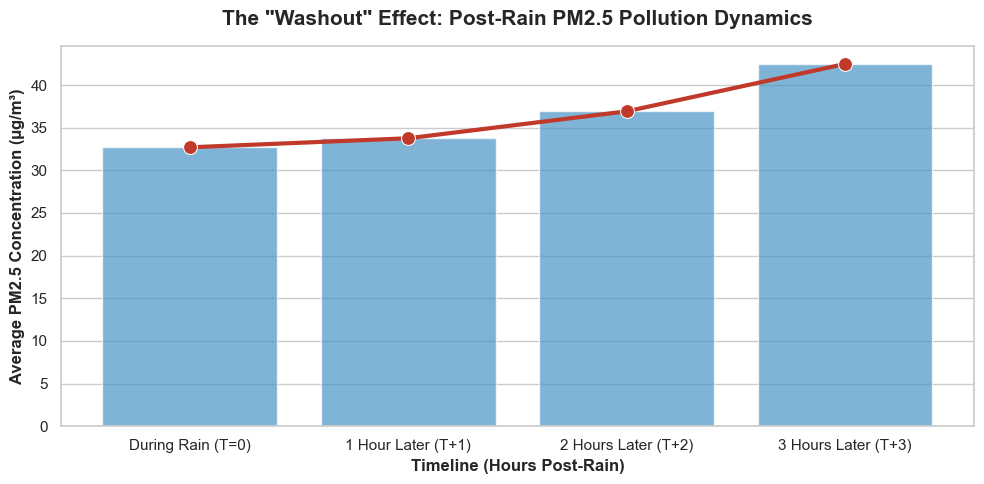

In [40]:
df_master['pm25_during_rain'] = df_master['pm_25']
df_master['pm25_1_hour_later'] = df_master['pm_25'].shift(-1)
df_master['pm25_2_hours_later'] = df_master['pm_25'].shift(-2)
df_master['pm25_3_hours_later'] = df_master['pm_25'].shift(-3)

heavy_rain = df_master[df_master['precipitation'] > 7.5]
washout_effect = heavy_rain[['pm25_during_rain', 'pm25_1_hour_later', 'pm25_2_hours_later', 'pm25_3_hours_later']].mean().reset_index()
washout_effect.columns = ['Time', 'PM25_Concentration']
washout_effect['Time'] = [
    'During Rain (T=0)', 
    '1 Hour Later (T+1)', 
    '2 Hours Later (T+2)', 
    '3 Hours Later (T+3)'
]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.barplot(data=washout_effect, x='Time', y='PM25_Concentration', color='#3498db', alpha=0.7)
sns.lineplot(data=washout_effect, x='Time', y='PM25_Concentration', color='#c0392b', marker='o', linewidth=3, markersize=10)

plt.title('The "Washout" Effect: Post-Rain PM2.5 Pollution Dynamics', fontsize=15, fontweight='bold', pad=15)
plt.ylabel('Average PM2.5 Concentration (µg/m³)', fontsize=12, fontweight='bold')
plt.xlabel('Timeline (Hours Post-Rain)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Observation:
Time-series analysis (T+0 to T+3) reveals that heavy rain acts as an instant air scrubber (Washout Effect), bringing PM2.5 to its lowest point exactly during the downpour (T=0). However, this effect is short-lived. Within 1 to 3 hours after the rain stops, PM2.5 levels aggressively climb back up by >25% due to resumed traffic activity.

Business Recomendation:
Cancel the proposed "Fresh Air / Go Out" marketing campaigns post-rain. Instead, utilize the 1-3 hour post-rain window to launch an Upsell Campaign for Car Ride Services. Push notifications should highlight the returning hazardous pollution, encouraging users to upgrade from motorcycle rides to car rides for health protection, thereby increasing the Average Order Value (AOV).